<a href="https://colab.research.google.com/drive/1Yh-M4nmlcsqjBGTVXxQErR5LF42KzdqH" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Auto-Encoder(CAE)

## 1. Load dataset

## 2. Import python libraries and define util functions

In [39]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss

In [40]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data

In [41]:
''' load data '''
src = os.path.join(data_path, 'data_3000')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (3000, 56, 56)
Y.shape: (3000,)


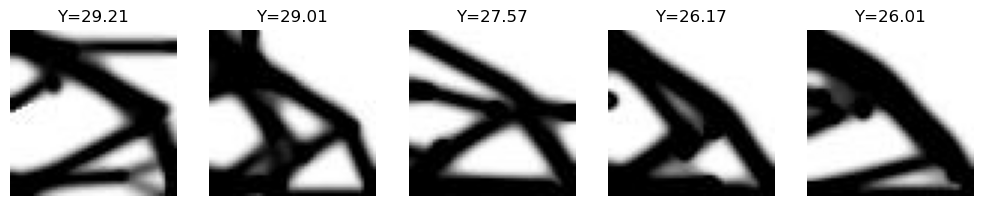

In [42]:
# check images
nplot = 5
idx = np.random.randint(1, 3000, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

In [43]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# # reshape (flatten) -> x conv
# X_tr = X_tr.reshape(-1, np.prod(X_tr.shape[1:])) # (2400, 56, 56) -> (2400, 56*56)
# X_ts = X_ts.reshape(-1, np.prod(X_ts.shape[1:]))

# print(X_tr.shape,X_ts.shape)


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device).unsqueeze(1)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

(2400, 56, 56) (600, 56, 56) (2400,) (600,)


## 5. Set to model architecture

In [44]:
# ''' model '''
# class ConvAutoencoder(nn.Module):
#     def __init__(self, conv_layers_channels=[16, 32, 64], conv_transpose_layers_channels=None):
#         super(ConvAutoencoder, self).__init__()

#         if conv_transpose_layers_channels is None:
#             conv_transpose_layers_channels = conv_layers_channels[::-1]
#             conv_transpose_layers_channels[-1] = 1
            
#         num_conv_t_layers = len(conv_transpose_layers_channels)
#         num_conv_layers = len(conv_layers_channels)

#         # encoder
#         self.encoder = nn.ModuleList()
#         in_channels = 1  # input channels (1 for grayscale images)
        
#         for i in range(num_conv_layers-1):
#             out_channels = conv_layers_channels[i]
#             self.encoder.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1))
#             self.encoder.append(nn.ReLU())
#             in_channels = out_channels

#         out_channels = conv_layers_channels[num_conv_layers-1]
#         self.encoder.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1))

#         # decoder
#         self.decoder = nn.ModuleList()
#         in_channels = out_channels
#         out_channels = conv_transpose_layers_channels[0]

#         for i in range(num_conv_t_layers-1):
#             out_channels = conv_transpose_layers_channels[i]
#             self.decoder.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
#             self.decoder.append(nn.ReLU())
#             in_channels = out_channels  # set the output channels of this layer as input for the next layer

#         out_channels = conv_transpose_layers_channels[num_conv_t_layers-1]
#         self.decoder.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

#     def forward(self, x):
#         for conv in self.encoder:
#             x = conv(x)
#         for conv in self.decoder:
#             x = conv(x)
#         return x

In [45]:
''' model '''
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 6. Set model hyperparameters

In [ ]:
# cae = ConvAutoencoder(conv_layers_channels=[32,64,128])
cae = ConvAutoencoder().to(device)

summary(cae, (1, 56, 56))  # input shape: (channels, height, width)
cae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
   ConvTranspose2d-6           [-1, 64, 14, 14]          73,792
              ReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8           [-1, 32, 28, 28]          18,464
              ReLU-9           [-1, 32, 28, 28]               0
  ConvTranspose2d-10            [-1, 1, 56, 56]             289
Total params: 185,217
Trainable params: 185,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.22
Params size (MB): 0.71
Estimated T

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [47]:
''' hyper params '''
num_epochs = 100
batch_size = 32
learning_rate = 1e-3

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=cae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

In [48]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, X_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 7. Train model

Epoch [ 1/100], Train loss: 0.057495


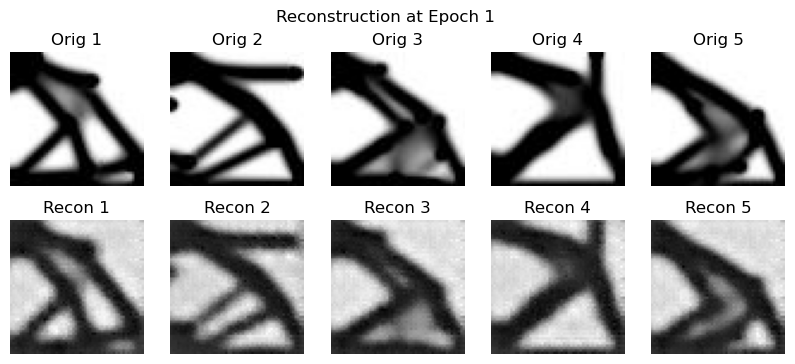

Epoch [ 2/100], Train loss: 0.003397
Epoch [ 3/100], Train loss: 0.001697
Epoch [ 4/100], Train loss: 0.001084
Epoch [ 5/100], Train loss: 0.000837
Epoch [ 6/100], Train loss: 0.000705
Epoch [ 7/100], Train loss: 0.000681
Epoch [ 8/100], Train loss: 0.000522
Epoch [ 9/100], Train loss: 0.000506
Epoch [10/100], Train loss: 0.000482
Epoch [11/100], Train loss: 0.000467
Epoch [12/100], Train loss: 0.000417
Epoch [13/100], Train loss: 0.000408
Epoch [14/100], Train loss: 0.000378
Epoch [15/100], Train loss: 0.000376
Epoch [16/100], Train loss: 0.000358
Epoch [17/100], Train loss: 0.000366
Epoch [18/100], Train loss: 0.000324
Epoch [19/100], Train loss: 0.000331
Epoch [20/100], Train loss: 0.000312
Epoch [21/100], Train loss: 0.000303
Epoch [22/100], Train loss: 0.000303
Epoch [23/100], Train loss: 0.000326
Epoch [24/100], Train loss: 0.000259
Epoch [25/100], Train loss: 0.000283
Epoch [26/100], Train loss: 0.000274
Epoch [27/100], Train loss: 0.000270
Epoch [28/100], Train loss: 0.000262
E

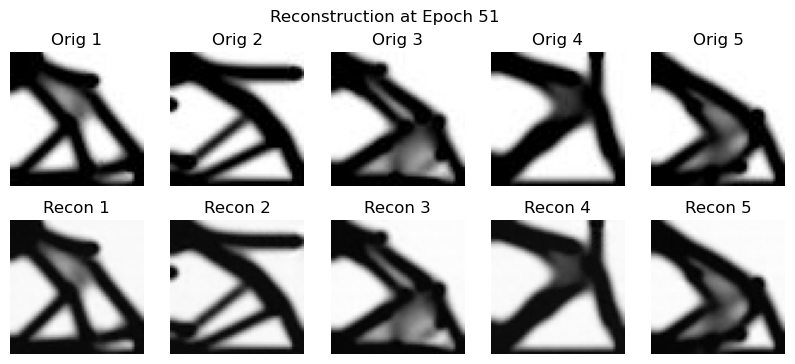

Epoch [52/100], Train loss: 0.000202
Epoch [53/100], Train loss: 0.000176
Epoch [54/100], Train loss: 0.000184
Epoch [55/100], Train loss: 0.000189
Epoch [56/100], Train loss: 0.000189
Epoch [57/100], Train loss: 0.000180
Epoch [58/100], Train loss: 0.000187
Epoch [59/100], Train loss: 0.000184
Epoch [60/100], Train loss: 0.000169
Epoch [61/100], Train loss: 0.000171
Epoch [62/100], Train loss: 0.000172
Epoch [63/100], Train loss: 0.000189
Epoch [64/100], Train loss: 0.000171
Epoch [65/100], Train loss: 0.000168
Epoch [66/100], Train loss: 0.000165
Epoch [67/100], Train loss: 0.000187
Epoch [68/100], Train loss: 0.000143
Epoch [69/100], Train loss: 0.000164
Epoch [70/100], Train loss: 0.000166
Epoch [71/100], Train loss: 0.000162
Epoch [72/100], Train loss: 0.000163
Epoch [73/100], Train loss: 0.000163
Epoch [74/100], Train loss: 0.000143
Epoch [75/100], Train loss: 0.000150
Epoch [76/100], Train loss: 0.000164
Epoch [77/100], Train loss: 0.000161
Epoch [78/100], Train loss: 0.000145
E

In [ ]:
''' train '''
loss_tr_hist = []

for epoch in range(num_epochs):
    
    # training
    cae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.unsqueeze(1)
        output = cae(x)
        # print(output.shape, x.shape)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss)
    print(f"Epoch [{epoch+1:2}/{num_epochs}], Train loss: {avg_loss:.6f}")

    scheduler.step()
    

    # validation
    if epoch % 50 == 0:
        cae.eval()
        with torch.no_grad():
            n = 5  # num of img

            plt.figure(figsize=(10, 4))
            
            for i in range(n):

                orig_img = X_ts.cpu()[i].reshape(56,56)
                recon_img = cae(X_ts[i]).detach().cpu().reshape(56,56)      # detach() : grad 연산 그래프에서 분리,     cpu() : gpu->cpu 복사

                # original
                ax = plt.subplot(2, n, i+1)
                plt.imshow(orig_img, cmap="gray")
                plt.title(f"Orig {i+1}")
                ax.axis('off')

                # recon
                ax = plt.subplot(2, n, i+1+n)
                plt.imshow(recon_img, cmap="gray")
                plt.title(f"Recon {i+1}")
                ax.axis('off')

            plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
            plt.show()
            cae.train()

# save model
torch.save(cae.state_dict(), os.path.join(model_path, 'CAE_model.pth'))

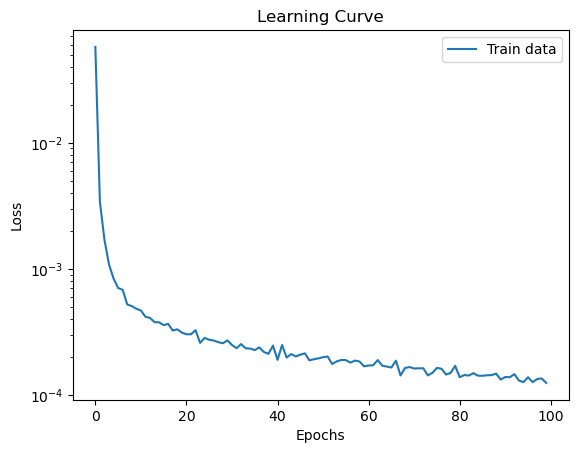

In [50]:
# graph visualization
plot_loss(loss_tr_hist, logy=True, title='Learning Curve')
plt.show()

## 8. Load & Evaluate model

- Compare the orginial image and the reconstructed image

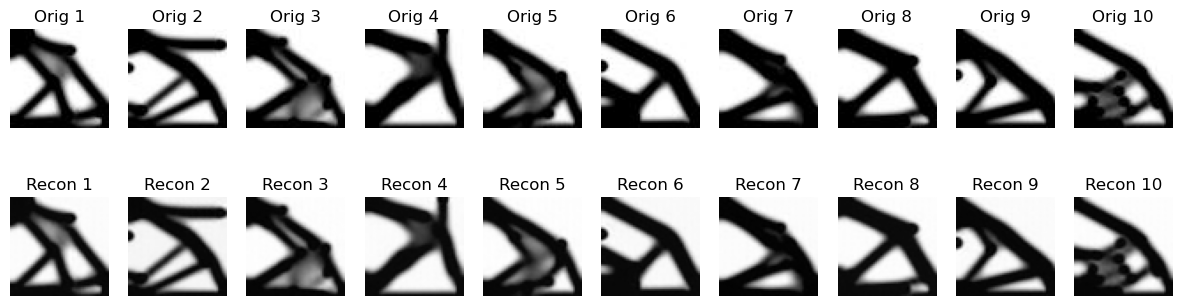

In [51]:
''' evaluation '''
cae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.squeeze().cpu()[i].reshape(56,56)
    recon_img = cae(X_ts[i]).squeeze().detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

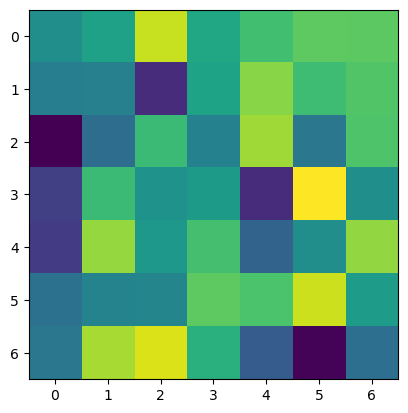

In [52]:
''' visulaize latent space '''
cae.eval()
with torch.no_grad():
    z = cae.encoder(X_ts).squeeze().cpu().detach().numpy()   # latent space(z)

plt.imshow(z[0][0])